In [ ]:
from collections import Counter
from typing import Self
import functools as ft

from ising.pauli import SiteBasis

import cvxpy as cp
import picos as pc
import numpy as np
import seaborn as sns
from sympy import symbols
from sympy.matrices import Matrix, zeros
from scipy.linalg import null_space, orth, eigvalsh
from scipy.special import ellipeinc
from scipy.sparse import csr_array
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from bitarray import bitarray
from bitarray.util import count_and

%load_ext line_profiler

In [ ]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def beta_independent_constraints(basis: SiteBasis, hamil: PauliSum) -> tuple[np.ndarray, np.ndarray]:
    # We handle normalization separately
    n_cols = basis.size() - 1
    A = np.zeros((n_cols, n_cols), dtype=complex)
    # A = zeros(n_cols, n_cols)
    for i, word in enumerate(basis._ops[1:]):
        psum = schwinger_dyson(hamil, word)
        if psum.is_zero():
            continue
        for pstr, weight in psum.terms.items():
            A[i, basis.rank(str(pstr)) - 1] += weight
    return 1j * A

In [5]:
def get_zero_ops(L, basis, small_basis):
    hamil = construct_hamil(L, 1)
    A = beta_independent_constraints(small_basis, hamil)
    A_real_ns = null_space(1j * A)
    print(A_real_ns.shape)
    zero_ops = set()
    for i, op in enumerate(basis._ops):
        if i == 0:
            continue
        if np.isclose(np.sum(A_real_ns[small_basis.rank(op) - 1, :]), 0):
            zero_ops.add(op)
    return zero_ops

def build_sparsity_matrix(basis: SiteBasis, zero_ops):
    small_basis = SiteBasis(basis._N, use_rot=True, use_reflect=True)
    sparsity = np.ones((basis.size(), basis.size()), dtype=np.int8)
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            if small_basis.normalize(str(PauliString(o1) * PauliString(o2))) in zero_ops:
                sparsity[i, j] = 0
    return sparsity

def build_phase_matrix(basis: SiteBasis, zero_ops):
    small_basis = SiteBasis(basis._N, use_rot=True, use_reflect=True)
    phase = np.ones((basis.size(), basis.size()), dtype=np.int8)
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            if small_basis.normalize(str(p1 * p2)) in zero_ops:
                phase[i, j] = 0
            else:
                p = p1.phase(p2)
                if np.isclose(p, -1j):
                    phase[i, j] = 1
                elif np.isclose(p, -1):
                    phase[i, j] = 2
                elif np.isclose(p, 1j):
                    phase[i, j] = 3
                elif np.isclose(p, 1):
                    phase[i, j] = 4
                else:
                    raise ValueError("Unexpected phase")
    return phase

def get_reorder(matrix):
    n_cc, labels = connected_components(csr_array(matrix), directed=False)
    reord = [y for y, _ in sorted(enumerate(labels), key=lambda x: x[1])]
    return n_cc, reord, labels

def get_bases(L):
    basis = SiteBasis(L)
    small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
    return basis, small_basis

def reorder_by_cc(matrix):
    reord = get_reorder(matrix)
    print(reord)
    return matrix[:, reord[1]][reord[1], :]

def plot_heatmap(matrix, basis, ax):
    print('Fraction of nonzeros:', len(np.nonzero(matrix)[0]) / basis.size() ** 2)
    sns.heatmap(matrix, xticklabels=False, yticklabels=False, ax=ax)

(54, 12)
(2, [0, 3, 5, 6, 9, 10, 12, 15, 17, 18, 20, 23, 24, 27, 29, 30, 33, 34, 36, 39, 40, 43, 45, 46, 48, 51, 53, 54, 57, 58, 60, 63, 65, 66, 68, 71, 72, 75, 77, 78, 80, 83, 85, 86, 89, 90, 92, 95, 96, 99, 101, 102, 105, 106, 108, 111, 113, 114, 116, 119, 120, 123, 125, 126, 129, 130, 132, 135, 136, 139, 141, 142, 144, 147, 149, 150, 153, 154, 156, 159, 160, 163, 165, 166, 169, 170, 172, 175, 177, 178, 180, 183, 184, 187, 189, 190, 192, 195, 197, 198, 201, 202, 204, 207, 209, 210, 212, 215, 216, 219, 221, 222, 225, 226, 228, 231, 232, 235, 237, 238, 240, 243, 245, 246, 249, 250, 252, 255, 1, 2, 4, 7, 8, 11, 13, 14, 16, 19, 21, 22, 25, 26, 28, 31, 32, 35, 37, 38, 41, 42, 44, 47, 49, 50, 52, 55, 56, 59, 61, 62, 64, 67, 69, 70, 73, 74, 76, 79, 81, 82, 84, 87, 88, 91, 93, 94, 97, 98, 100, 103, 104, 107, 109, 110, 112, 115, 117, 118, 121, 122, 124, 127, 128, 131, 133, 134, 137, 138, 140, 143, 145, 146, 148, 151, 152, 155, 157, 158, 161, 162, 164, 167, 168, 171, 173, 174, 176, 179, 181, 1

<Axes: >

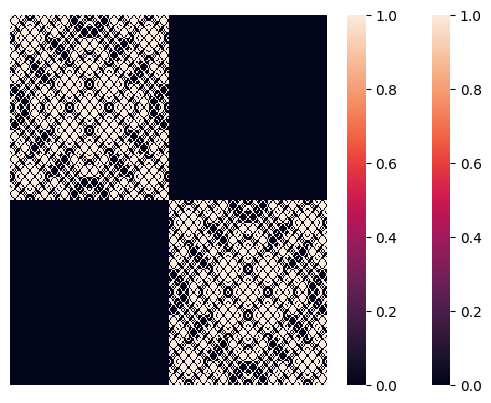

In [23]:
L = 4
basis, small_basis = get_bases(L)
sparsity = build_sparsity_matrix(basis, get_zero_ops(L, basis, small_basis))
sns.heatmap(sparsity, xticklabels=False, yticklabels=False)
reord_sparsity = reorder_by_cc(sparsity)
sns.heatmap(reord_sparsity, xticklabels=False, yticklabels=False)
# sparsity_small = build_sparsity_matrix(small_basis, get_zero_ops(L, basis, small_basis))
# reord_sparsity_small = reorder_by_cc(sparsity_small)
# phase = build_phase_matrix(basis, get_zero_ops(L))
# reord_phase = reorder_by_cc(phase)
# phase_small = build_phase_matrix(small_basis, get_zero_ops(L))
# reord_phase_small = reorder_by_cc(phase_small)

Fraction of nonzeros: 0.28125
Fraction of nonzeros: 0.28125
Fraction of nonzeros: 0.3150413223140496
Fraction of nonzeros: 0.3150413223140496


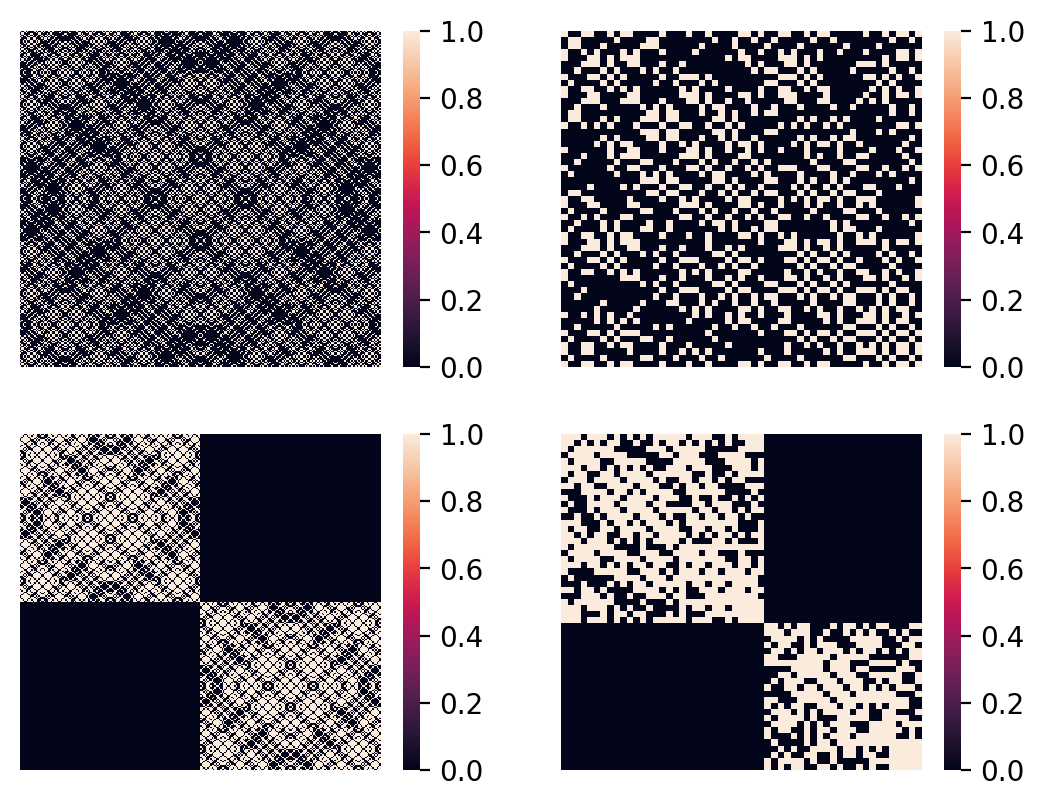

In [454]:
fig, axs = plt.subplots(2, 2)
plot_heatmap(sparsity, basis, axs[0, 0])
plot_heatmap(reord_sparsity, basis, axs[1, 0])
plot_heatmap(sparsity_small, small_basis, axs[0, 1])
plot_heatmap(reord_sparsity_small, small_basis, axs[1, 1])
fig.set_dpi(200)
plt.show()

Fraction of nonzeros: 0.28125
Fraction of nonzeros: 0.28125
Fraction of nonzeros: 0.3150413223140496
Fraction of nonzeros: 0.3150413223140496


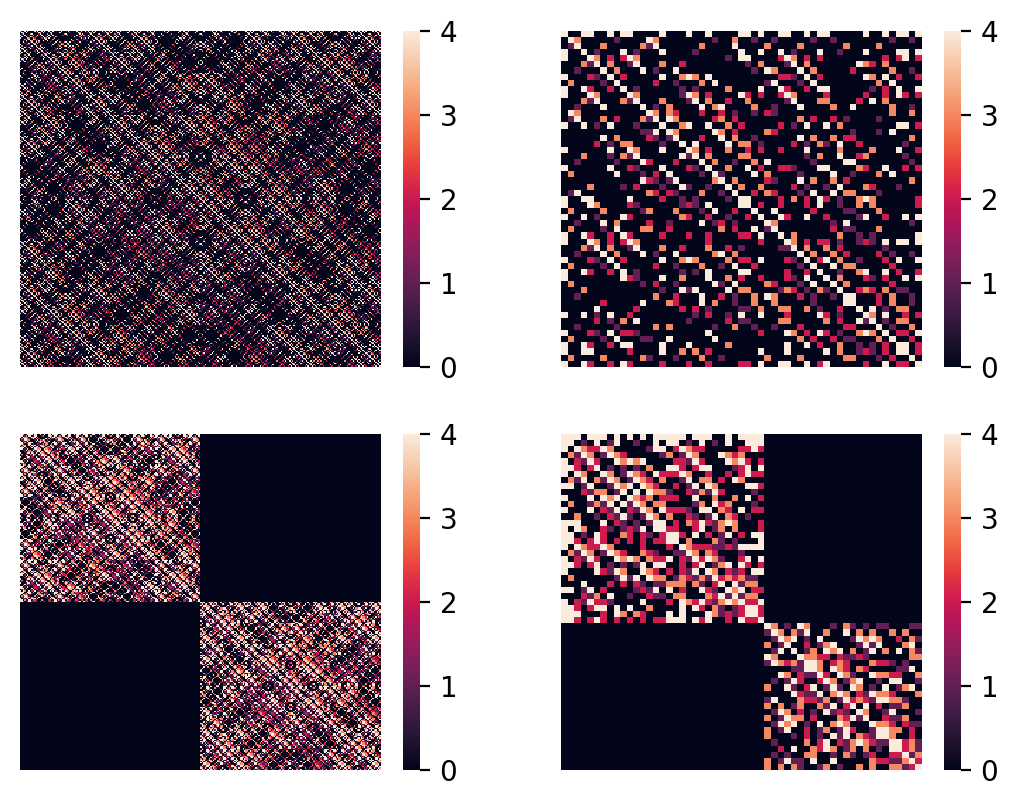

In [455]:
fig, axs = plt.subplots(2, 2)
plot_heatmap(phase, basis, axs[0, 0])
plot_heatmap(reord_phase, basis, axs[1, 0])
plot_heatmap(phase_small, small_basis, axs[0, 1])
plot_heatmap(reord_phase_small, small_basis, axs[1, 1])
fig.set_dpi(200)
plt.show()

In [6]:
# Now decompose everything

def decompose(op: PauliSum, A_ns, small_basis):
    res = np.zeros(A_ns.shape[1], dtype=np.complex128)
    for pstr, weight in op.terms.items():
        res += weight * A_ns[small_basis.rank(str(pstr)) - 1, :]
    return res

def get_decomp(A_ns, ops, small_basis):
    decomp_mats = np.zeros((A_ns.shape[1], len(ops), len(ops)), dtype=np.complex128)
    for i, o1 in enumerate(ops):
        for j, o2 in enumerate(ops):
            if i <= j:
                continue
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            p3 = p1 * p2
            decomp_mats[:, i, j] += p1.phase(p2) * A_ns[small_basis.rank(str(p3)) - 1, :]
    return decomp_mats + decomp_mats.conj().transpose((0, 2, 1))

def decompose_sb(op: PauliSum, small_basis):
    res = np.zeros(small_basis.size() - 1, dtype=np.complex128)
    for pstr, weight in op.terms.items():
        res[small_basis.rank(str(pstr)) - 1] += weight
    return res

def get_decomp_sb(ops, small_basis):
    decomp_mats = np.zeros((small_basis.size() - 1, len(ops), len(ops)), dtype=np.complex128)
    for i, o1 in enumerate(ops):
        for j, o2 in enumerate(ops):
            if i <= j:
                continue
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            p3 = p1 * p2
            decomp_mats[small_basis.rank(str(p3)) - 1, i, j] += p1.phase(p2)
    return decomp_mats + decomp_mats.conj().transpose((0, 2, 1))

In [64]:
def analytical_energy(h):
    return (2 * np.abs(1 - h) / np.pi) * ellipeinc(np.pi / 2, -4 * h / (1 - h) ** 2)

def calculated_energy(L, h):
    H = construct_hamil(L, h).to_matrix()
    return eigvalsh(H, subset_by_index=[0, 0])[0]

def calculated_energies(L, hs):
    energies = np.zeros_like(hs)
    for i, h in enumerate(hs):
        print(f'Solving {h:.4f}...')
        energies[i] = -calculated_energy(L, h)/L
    return energies

def dm_energy(L, h):
    prob = pc.Problem()
    hamil = construct_hamil(L, h)
    H = np.real(hamil.to_matrix())
    # H = csr_array(hamil.to_matrix())
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", rho | H)
    C = 1
    prob.add_constraint(pc.trace(rho) == C)
    prob.add_constraint(rho >> 0)
    prob.solve(primals=None)
    return prob.value / C

def dm_energies(L, hs):
    energies = np.zeros_like(hs)
    for i, h in enumerate(hs):
        # print(f'Solving {h:.4f}...')
        energies[i] = -dm_energy(L, h).value/L
    return energies

def get_energy(hamil, small_basis, Ai_s1, Ai_s2) -> pc.Solution:
    prob = pc.Problem()
    # A = beta_independent_constraints(small_basis, hamil)
    # A_ns = null_space(A)
    # Ai_s1 = get_decomp(A_ns, spops1, small_basis)
    # Ai_s2 = get_decomp(A_ns, spops2, small_basis)
    # decomp_hamil = decompose(hamil, A_ns, small_basis)
    decomp_hamil = decompose_sb(hamil, small_basis)
    # This is the primal problem
    X = pc.SymmetricVariable("X", Ai_s1.shape[1])
    Y = pc.SymmetricVariable("Y", Ai_s2.shape[1])
    # v = pc.RealVariable("v", small_basis.size())
    prob.set_objective("max", -(pc.trace(X) + pc.trace(Y)))
    # prob.set_objective("max", -pc.trace(X))
    prob.add_constraint(X >> 0)
    prob.add_constraint(Y >> 0)
    prob.add_list_of_constraints([(Ai_s1[i] | X) + (Ai_s2[i] | Y) == decomp_hamil[i] for i in range(Ai_s1.shape[0])])
    # prob.add_list_of_constraints([(Ai_s1[i] | X) == decomp_hamil[i] for i in range(Ai_s1.shape[0])])
    # print(prob)
    return prob.solve()
    # This is the dual problem
    # x = pc.RealVariable("x", (A_ns.shape[1], 1))
    # prob.set_objective("min", decomp_hamil.T * x)
    # prob.add_constraint(pc.I(len(spops1)) + pc.sum([Ai_s1[i] * x[i] for i in range(A_ns.shape[1])]) >> 0)
    # prob.add_constraint(pc.I(len(spops2)) + pc.sum([Ai_s2[i] * x[i] for i in range(A_ns.shape[1])]) >> 0)
    # return prob.solve(dualize=True)

def get_energy_cvxpy(hamil, small_basis, Ai_s1, Ai_s2) -> pc.Solution:
    decomp_hamil = decompose_sb(hamil, small_basis)
    # This is the primal problem
    X = cp.Variable((Ai_s1.shape[1], Ai_s1.shape[1]), "X", PSD=True)
    Y = cp.Variable((Ai_s2.shape[1], Ai_s2.shape[1]), "Y", PSD=True)
    obj =  -(cp.trace(X) + cp.trace(Y))
    constraints = [cp.trace(Ai_s1[i] @ X) + cp.trace(Ai_s2[i] @ Y) == decomp_hamil[i] for i in range(Ai_s1.shape[0])]
    prob = cp.Problem(cp.Maximize(obj), constraints)
    return prob.solve()

def get_energies(L, hs):
    basis, small_basis = get_bases(L)
    hamil = construct_hamil(L, 1)
    A_ns = null_space(beta_independent_constraints(small_basis, hamil))
    # Now build the ops from the sparsity pattern
    solve_basis = small_basis
    zero_ops = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
    sparsity = np.ones((solve_basis.size(), solve_basis.size()), dtype=np.int8)
    for i, o1 in enumerate(solve_basis._ops):
        for j, o2 in enumerate(solve_basis._ops):
            if i <= j:
                continue
            op = small_basis.rank(str(PauliString(o1) * PauliString(o2)))
            if op in zero_ops:
                sparsity[i, j] = sparsity[j, i] = 0
    _, reord = get_reorder(sparsity)
    spops1 = np.array(solve_basis._ops)[reord[:len(reord) // 2]]
    spops2 = np.array(solve_basis._ops)[reord[len(reord) // 2:]]
    Ai_s1 = get_decomp_sb(spops1, small_basis)
    Ai_s2 = get_decomp_sb(spops2, small_basis)
    energies = np.zeros_like(hs)
    for i, h in enumerate(hs):
        print(f'Solving {h:.4f}...')
        hamil = construct_hamil(L, h)
        # energies[i] = -get_energy_cvxpy(hamil, small_basis, Ai_s1, Ai_s2)/L
        energies[i] = -get_energy(hamil, small_basis, Ai_s1, Ai_s2).value/L
    return energies

In [65]:
dm_energy(3, 1)

-3.9999999999999885

In [9]:
Ls = [2, 3, 4]
hs = np.linspace(1e-3, 2, num=10)
aE = analytical_energy(hs)
for L in Ls:
    print(f'Solving {L}')
    # plt.plot(hs, 100 * np.abs(get_energies(L, hs) - aE) / aE, label=f'L = {L} (basis)')
    plt.plot(hs, 100 * np.abs(dm_energies(L, hs) - aE) / aE, label=f'L = {L} (DM)')
plt.axvline(1, linestyle='--', c='black')
plt.xlim(0,2)
plt.ylabel('Percent error')
plt.legend()
plt.show()

Solving 2


SolutionFailure: Code 3: Primal solution state claimed unknown but optimality is required (primals=True).

In [507]:
%lprun -f get_energy get_energies(4, np.array([1]))

Solving 1.0000...


Timer unit: 1e-07 s

Total time: 1.80675 s
File: C:\Users\Mainak\AppData\Local\Temp\ipykernel_18300\4291279164.py
Function: get_energy at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def get_energy(L, h, small_basis, spops1, spops2) -> pc.Solution:
     5         1       1907.0   1907.0      0.0      prob = pc.Problem()
     6         1       4255.0   4255.0      0.0      hamil = construct_hamil(L, h)
     7         1     146316.0 146316.0      0.8      A = beta_independent_constraints(small_basis, hamil)
     8                                               # A_ns = null_space(A)
     9                                               # Ai_s1 = get_decomp(A_ns, spops1, small_basis)
    10                                               # Ai_s2 = get_decomp(A_ns, spops2, small_basis)
    11                                               # decomp_hamil = decompose(hamil, A_ns, small_basis)
    12         1    1591457.0 